# COURSE: A deep understanding of deep learning
## SECTION: FFNs
### LECTURE: FFN to classify digits
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202212

In [32]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-32-a8aed9fadacf>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [33]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data   = data[:,1:]

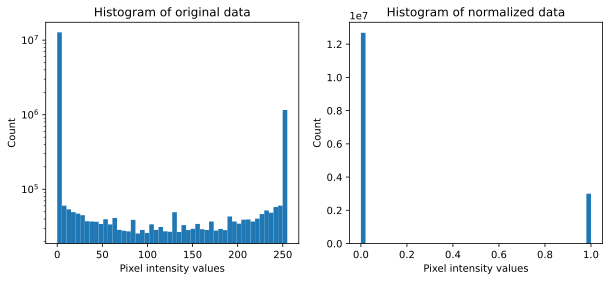

In [34]:
# normalize the data to a range of [0 1]
dataNorm = (data > 0).astype(float)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')
ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

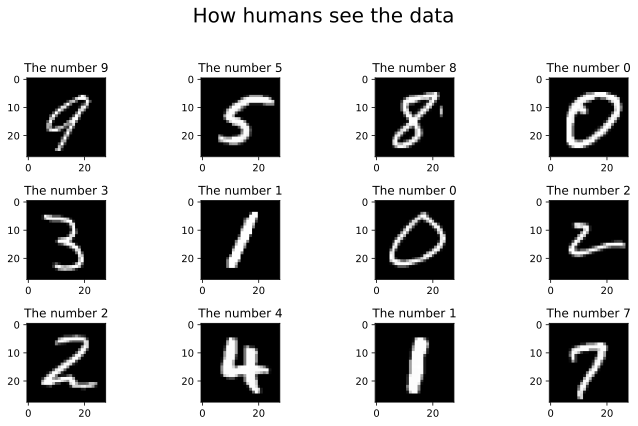

In [51]:
np.random.seed(2)
# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0,high=data.shape[0])

  # create the image (must be reshaped!)
  img = np.reshape(data[randimg2show,:],(28,28))
  ax.imshow(img,cmap='gray')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('How humans see the data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

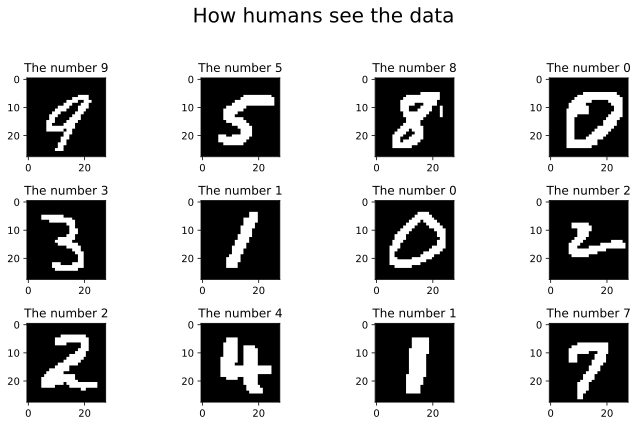

In [52]:
np.random.seed(2)

# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0,high=dataNorm.shape[0])

  # create the image (must be reshaped!)
  img = np.reshape(dataNorm[randimg2show,:],(28,28))
  ax.imshow(img,cmap='gray')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('How humans see the data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

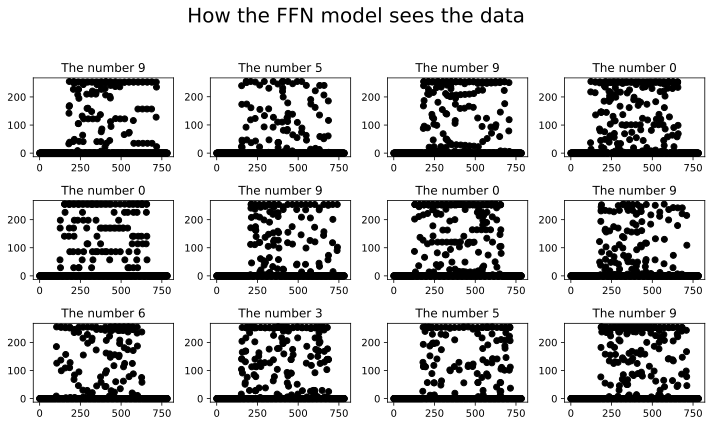

In [37]:
# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0,high=data.shape[0])

  # create the image
  ax.plot(data[randimg2show,:],'ko')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('How the FFN model sees the data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

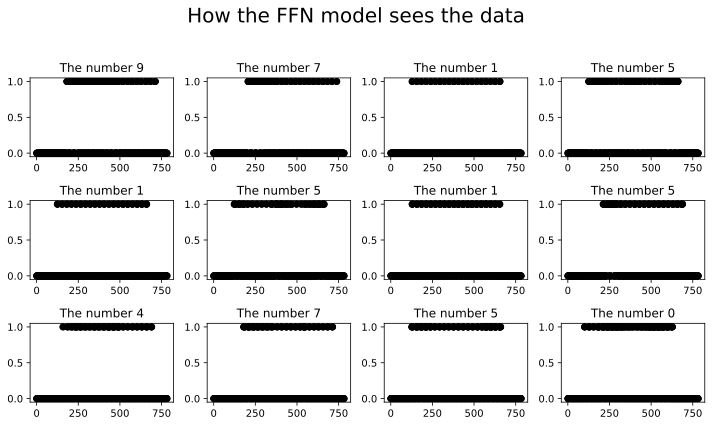

In [38]:
# show a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0,high=dataNorm.shape[0])

  # create the image
  ax.plot(dataNorm[randimg2show,:],'ko')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('How the FFN model sees the data',fontsize=20)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

# Create train/test groups using DataLoader

In [39]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [40]:
# check all variables in workspace
%whos

Variable                Type             Data/Info
--------------------------------------------------
DataLoader              type             <class 'torch.utils.data.dataloader.DataLoader'>
F                       module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset           type             <class 'torch.utils.data.dataset.TensorDataset'>
X                       Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
avgCorr                 Tensor           tensor([[0.0000, 0.0000, <...>0000,\n         0.0000]])
avgErr                  Tensor           tensor([[0.0000, 0.0000, <...>0000,\n         0.0000]])
ax                      Axes             Axes(0.785472,0.064537;0.199528x0.182685)
axs                     ndarray          3x4: 12 elems, type `object`, 96 bytes
batchsize               int              32
binariazed_data         ndarray          20000x784: 15680000 elems, type `int64`, 125440000 bytes (119.62890625 Mb)
corrInd

# Create the DL model

In [41]:
# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,64)

      ### hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)

      ### output layer
      self.output = nn.Linear(32,10)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return torch.log_softmax( self.output(x),axis=1 )
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss

  # create the model instance
  net = mnistNet()

  # loss function
  lossfun = nn.NLLLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [42]:
# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X,y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(yHat))
# print(torch.exp(yHat))
# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
Loss:
tensor(2.3202, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [43]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 60

  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


# Run the model and show the results!

In [44]:
trainAcc,testAcc,losses,net = funtion2trainTheModel()


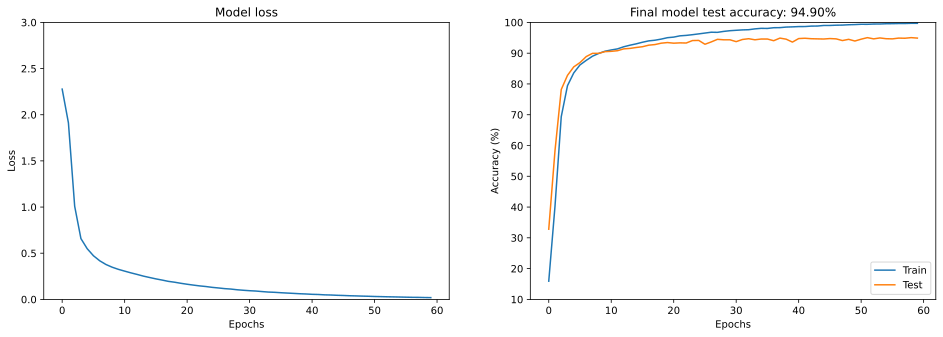

In [45]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Inspect the results in more detail

In [46]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

torch.exp(predictions)

tensor([[2.4764e-10, 4.6504e-13, 2.2337e-11,  ..., 3.8221e-06, 1.9738e-09,
         9.9998e-01],
        [4.8957e-10, 4.7347e-07, 3.3668e-09,  ..., 6.2911e-05, 4.8542e-06,
         7.7568e-05],
        [1.2492e-09, 1.8036e-04, 7.6214e-07,  ..., 1.9380e-05, 4.5728e-05,
         9.9918e-01],
        ...,
        [7.7248e-14, 9.9979e-01, 4.7941e-08,  ..., 3.2340e-07, 2.0818e-04,
         2.9199e-06],
        [9.8033e-10, 7.8635e-12, 9.6191e-09,  ..., 9.9990e-01, 6.2616e-11,
         6.8296e-05],
        [7.5280e-13, 9.9929e-01, 1.1548e-06,  ..., 4.4433e-07, 6.9165e-04,
         5.3999e-06]])

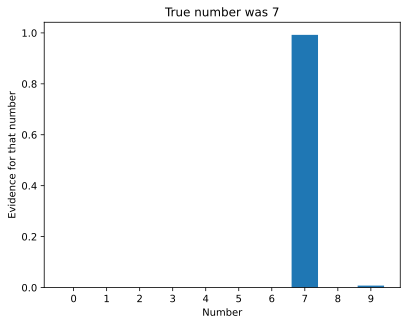

In [47]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10),torch.exp(predictions[sample2show])) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' %y[sample2show].item())
plt.show()

[  65   66   72   91  113  141  159  173  193  222  226  245  253  276
  305  327  330  358  363  370  406  430  466  489  515  536  547  556
  559  597  612  630  637  668  699  719  736  737  740  755  785  788
  806  827  876  887  933  942  953  954  960  965  987  998 1055 1060
 1108 1125 1128 1171 1226 1258 1263 1312 1320 1342 1347 1391 1472 1492
 1500 1518 1523 1560 1567 1602 1620 1653 1655 1657 1658 1671 1681 1697
 1723 1744 1757 1771 1781 1782 1793 1852 1866 1880 1881 1918 1931 1959
 1980 1983 1988 1991]


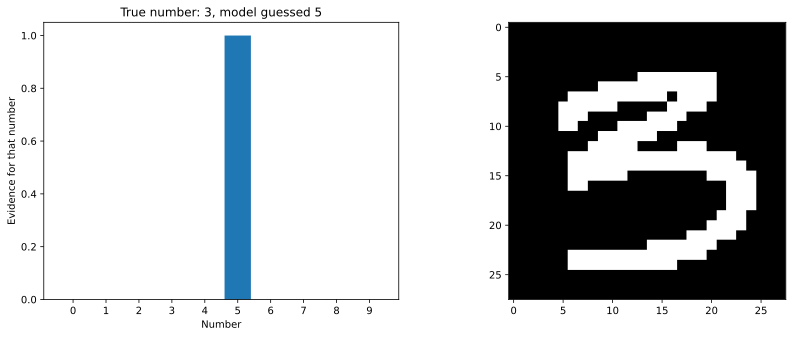

In [48]:
# find the errors
errors = np.where( torch.max(predictions,axis=1)[1] != y )[0]
print(errors)

# Evidence for all numbers from one sample
sample2show = 5

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].bar(range(10),np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:],(28,28)) ,cmap='gray')

plt.show()

# Additional explorations

In [49]:
# 1) Average together the correct 7's and the error 7's, and make images of them (that is, one image
#    of all correct 7's and one image of all incorrectly labeled 7's). How do they look?
#
# 2) Repeat #1 for all numbers to produce a 2x10 matrix of images with corrects on top
#    and errors on the bottom.
#
# 3) Identify "almost errors," which we can define as correct categorizations that had a probability of
#    e.g., >.1 for any other number. Make images of some of these numbers. Can you understand why the model
#    was confused?
#
# 4) I didn't use .train(), .eval(), or no_grad() here. Is that a problem? Can you add those in without checking
#    other notebooks?
#

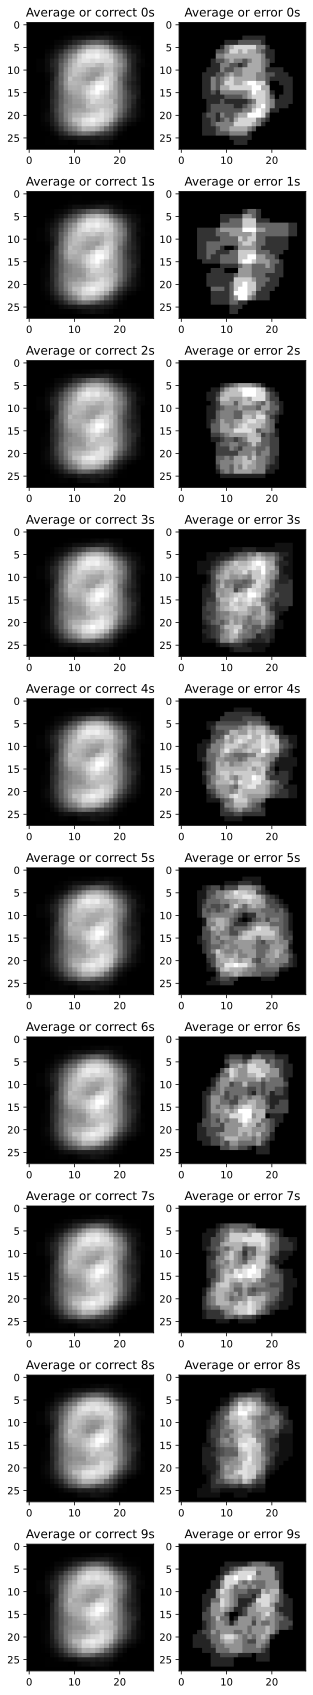

In [50]:
fig,ax = plt.subplots(10,2,figsize=(5,30))

for i in range(10):

    inds = np.where(y == i)[0]

    corrInds = np.where(torch.max(predictions[inds,:],axis=1)[1] == i)[0]
    errInds = np.where(torch.max(predictions[inds,:],axis=1)[1] != i)[0]

    avgCorr = np.reshape(torch.mean(X[corrInds,:],axis=0), (28,28))
    avgErr = np.reshape(torch.mean(X[errInds,:],axis=0), (28,28))

    ax[i,0].imshow(avgCorr,cmap='gray')
    ax[i,0].set_title(f"Average or correct {i}s")

    ax[i,1].imshow(avgErr,cmap='gray')
    ax[i,1].set_title(f"Average or error {i}s")

plt.show()